# Introdução

**Integrantes:**
- Francisco Lou - 2211275
- Vinicius Araujo - 2210392
- Felipe Fortini - 2220501
- Luca Lima - 2210831
- João Felipe Motta - 2211721

Neste trabalho, iremos:

- **Apresentar o objetivo**: Trabalhar com os dados e usar modelos para classificar risco de crédito.
- **Descrever o dataset**: "German Credit", composto por 1.000 registros e 9 atributos selecionados.


In [9]:
# imports
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
#Carregar dados
df = pd.read_csv('class_german_credit.csv')

# Mostrar dimensões 
print("Dimensões:", df.shape)

df.info()

# Mostrar primeiras linhas de dados
df.head()

Dimensões: (1000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


# Descrição dos Atributos

### 1. **Age**
- **Tipo:** Numérico
- **Escala:** Razão
- **Cardinalidade:** Contínua
- **Explicação:** Idade em anos, com zero significativo e intervalo praticamente contínuo.

### 2. **Sex**
- **Tipo:** Categórico
- **Escala:** Nominal
- **Cardinalidade:** Binária
- **Explicação:** Male/female, sem hierarquia e com duas categorias.

### 3. **Job**
- **Tipo:** Numérico
- **Escala:** Razão
- **Cardinalidade:** Discreta
- **Explicação:** Níveis de emprego codificados em inteiros de 0 a 3.

### 4. **Housing**
- **Tipo:** Categórico
- **Escala:** Nominal
- **Cardinalidade:** Discreta
- **Explicação:** Tipo de moradia (own/rent/free), sem ordem.

### 5. **Saving accounts**
- **Tipo:** Categórico
- **Escala:** Nominal
- **Cardinalidade:** Discreta
- **Explicação:** Categorias de saldo (little, moderate, quite rich, rich).

### 6. **Checking account**
- **Tipo:** Categórico
- **Escala:** Nominal
- **Cardinalidade:** Discreta
- **Explicação:** Categorias de saldo em conta corrente (little, moderate, rich, etc.), sem relação ordinal numérica.

### 7. **Credit amount**
- **Tipo:** Numérico
- **Escala:** Razão
- **Cardinalidade:** Contínua
- **Explicação:** Valor do empréstimo em DM, com zero significativo e contínuo.

### 8. **Duration**
- **Tipo:** Numérico
- **Escala:** Razão
- **Cardinalidade:** Discreta
- **Explicação:** Duração em meses, valores inteiros.

### 9. **Purpose**
- **Tipo:** Categórico
- **Escala:** Nominal
- **Cardinalidade:** Discreta
- **Explicação:** Finalidade do crédito, sem hierarquia.

### 10. **Risk**
- **Tipo:** Categórico
- **Escala:** Nominal
- **Cardinalidade:** Binária
- **Explicação:** Alvo do modelo, good/bad.

In [6]:
descr = pd.DataFrame({
    'Atributo': [
        'Age', 'Sex', 'Job', 'Housing',
        'Saving accounts', 'Checking account',
        'Credit amount', 'Duration', 'Purpose', 'Risk'
    ],
    'Tipo': [
        'Numérico', 'Categórico', 'Numérico', 'Categórico',
        'Categórico', 'Categórico',
        'Numérico', 'Numérico', 'Categórico', 'Categórico'
    ],
    'Escala': [
        'Razão', 'Nominal', 'Razão', 'Nominal',
        'Nominal', 'Nominal',
        'Razão', 'Razão', 'Nominal', 'Nominal'
    ],
    'Cardinalidade': [
        'Contínua', 'Binária', 'Discreta', 'Discreta',
        'Discreta', 'Discreta',
        'Contínua', 'Discreta', 'Discreta', 'Binária'
    ]
})

descr

,Atributo,Tipo,Escala,Cardinalidade
0,Age,Numérico,Razão,Contínua
1,Sex,Categórico,Nominal,Binária
2,Job,Numérico,Razão,Discreta
3,Housing,Categórico,Nominal,Discreta
4,Saving accounts,Categórico,Nominal,Discreta
5,Checking account,Categórico,Nominal,Discreta
6,Credit amount,Numérico,Razão,Contínua
7,Duration,Numérico,Razão,Discreta
8,Purpose,Categórico,Nominal,Discreta
9,Risk,Categórico,Nominal,Binária


# Estatísticas Descritivas e Análise Exploratória

Aqui vamos:

1. Calcular estatísticas descritivas para os atributos numéricos (média, desvio-padrão, mínimo, máximo, etc.).
2. Gerar tabelas de frequência para os atributos categóricos.
3. Plotar visualizações simples (histogramas e boxplots) para identificar distribuições e possíveis outliers.

In [7]:
num_cols = ['Age', 'Credit amount', 'Duration']
stats_num = df[num_cols].describe().T
stats_num['missing'] = df[num_cols].isna().sum()
stats_num

,count,mean,std,min,25%,50%,75%,max,missing
Age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0,0
Credit amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0,0
Duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0,0


## Atributos Numéricos

### Age
- **Média:** 35,55 anos  
- **Desvio-padrão:** 11,38 anos  
- **Mínimo:** 19 anos  
- **Máximo:** 75 anos  
- **Comentário:** A idade dos solicitantes varia de jovens adultos (19 anos) até seniores (75 anos), com concentração em torno dos 27–42 anos (25º–75º percentis). A dispersão moderada (std ~11) indica boa variedade etária, sem registros faltantes.  

### Credit amount
- **Média:** 3271,26 DM  
- **Desvio-padrão:** 2822,74 DM  
- **Mínimo:** 250 DM  
- **Máximo:** 18 424 DM  
- **Comentário:** Há grande amplitude de valores de empréstimo, de apenas 250 DM até 18 424 DM. A alta dispersão (std quase igual à média) sugere a presença de empréstimos muito elevados como outliers potenciais.  

### Duration
- **Média:** 20,90 meses  
- **Desvio-padrão:** 12,06 meses  
- **Mínimo:** 4 meses  
- **Máximo:** 72 meses  
- **Comentário:** A duração típica fica entre 12 e 24 meses (25º–75º percentis), mas há casos extremos de curta (4 meses) e longa duração (72 meses). A variabilidade indica perfis diferenciados de pagamento, sem valores ausentes.  

### Valores Faltantes
- Todas as três colunas numéricas apresentam **0 missing**.  

---

## Frequência dos Atributos Categóricos

- **Sex:** 69,0 % male, 31,0 % female.  
- **Job:** 63,0 % nível 2 (skilled), 20,0 % nível 1, 14,8 % nível 3, 2,2 % nível 0.  
- **Housing:** 71,3 % own, 17,9 % rent, 10,8 % free.  
- **Saving accounts:** 60,3 % little, 10,3 % moderate, 6,3 % quite rich, 4,8 % rich; 18,3 % missing.  
- **Checking account:** 27,4 % little, 26,9 % moderate, 6,3 % rich; 39,4 % missing.  
- **Purpose:** 33,7 % car, 28,0 % radio/TV, 18,1 % furniture/equipment, 9,7 % business, 5,9 % education, 2,2 % repairs, 1,2 % domestic appliances, 1,2 % vacation/others.  
- **Risk:** 70,0 % good, 30,0 % bad.  

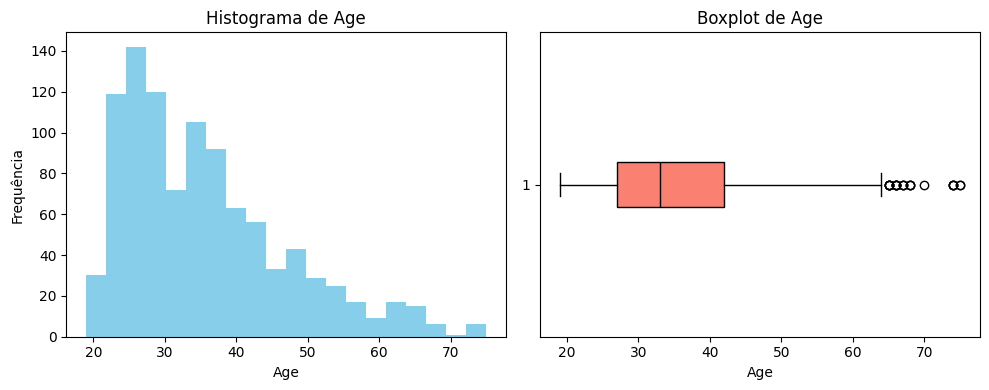

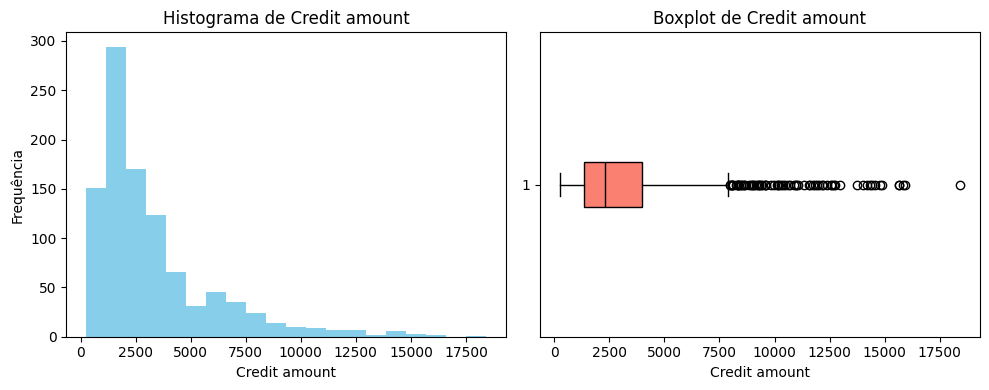

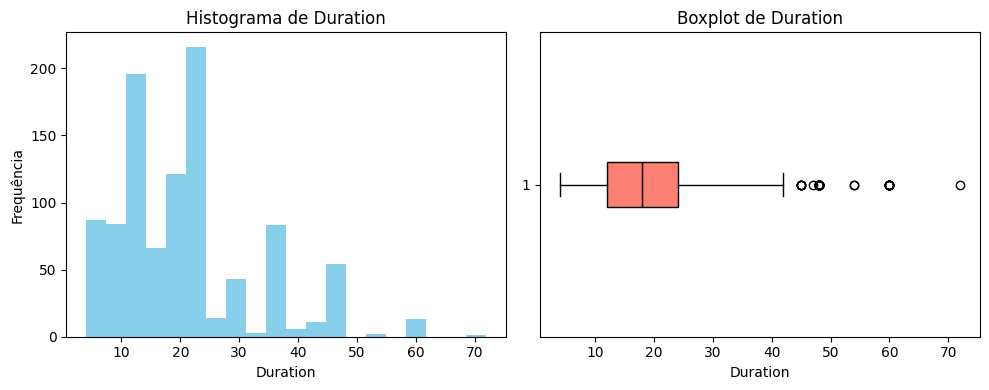

In [10]:
for col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)
    
    # Histograma
    axes[0].hist(df[col].dropna(), bins=20, color='skyblue')
    axes[0].set_title(f"Histograma de {col}")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Frequência")
    
    # Boxplot
    axes[1].boxplot(df[col].dropna(), vert=False, patch_artist=True,
                    boxprops=dict(facecolor='salmon'),
                    medianprops=dict(color='black'))
    axes[1].set_title(f"Boxplot de {col}")
    axes[1].set_xlabel(col)
    
    plt.tight_layout()
    plt.show()

# Análise das Distribuições e Outliers

## Distribuição de Idade (Age)
- **Assimetria (skew):** O histograma de *Age* mostra concentração maior entre 20 e 40 anos, com cauda direita estendendo-se até 75 anos. Isso indica **skew positivo (right-skewed)**.  
- **Outliers:** No boxplot, há pontos acima de ~60 anos que aparecem como outliers.  
- **Remoção?:** Esses valores extremos refletem clientes seniores válidos; não devem ser removidos, apenas monitorados no modelo.  

---

## Distribuição de Empréstimo (Credit amount)
- **Assimetria (skew):** O histograma de *Credit amount* é fortemente **right-skewed**, com a maior parte dos empréstimos entre 250 e 5 000 DM e longa cauda até ~18 424 DM.  
- **Outliers:** Muitos empréstimos acima de ~7 500 DM surgem como outliers no boxplot.  
- **Remoção?:** Esses “outliers” representam empréstimos altos reais e não devem ser eliminados. Como alternativa, pode-se aplicar **log-transform** para amenizar o skew antes de modelar.  

---

## Distribuição de Duração (Duration)
- **Assimetria (skew):** O histograma de *Duration* mostra um pico em torno de 12–24 meses e cauda à direita até 72 meses, indicando **ligeiro right-skew**.  
- **Outliers:** O boxplot aponta durações acima de ~36 meses como outliers.  
- **Remoção?:** Empréstimos de longa duração são plausíveis; manteremos esses casos, mas poderemos testar **discretização ou transformação** caso prejudiquem o modelo.  